# Fuzzy Name Matching
## Modeling

### This notebook analyzes the fuzzy name matching data using the following models.
1. XGBoost Classifier
2. Decision Tree Classifier
3. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [3]:
# Interim Data File Locations
interim_data = '../data/interim/'

In [4]:
df = pd.read_csv(interim_data + 'feature_engineering_results.csv')
df.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(97108, 55)

In [5]:
df[df.confidential==0].sample(10)

,key,list_first_name,list_last_name,txn_first_name,txn_last_name,is_match,confidential,syll_list_first,syll_txn_first,syll_list_last,...,higueramico_first,higueramico_last,sift4_first,sift4_last,eudex_first,eudex_last,aline_first,aline_last,phoneticeditdistance_first,phoneticeditdistance_last
64664,2573,char,poulin,charlie,poulin,1,0,['char'],"['char', 'lie']","['pou', 'lin']",...,0.490476,1.000000,0.571429,1.000000,0.990196,1.000000,0.648649,1.000000,0.571429,1.000000
96159,34072,veki,dowe,draza,bermudez,0,0,"['ve', 'ki']","['dra', 'za']","['do', 'we']",...,0.000000,0.000000,0.000000,0.125000,0.669118,0.810294,0.266667,0.211364,0.661290,0.451613
82189,20100,charlie,morrell,petr,stuart,0,0,"['char', 'lie']",['petr'],"['mor', 'rell']",...,0.061905,0.107143,0.142857,0.142857,0.801961,0.786275,0.264865,0.324390,0.511521,0.684332
92074,29986,nette,bembry,phil,gayton,0,0,"['net', 'te']",['phil'],"['bem', 'bry']",...,0.000000,0.019841,0.000000,0.166667,0.805882,0.921078,0.244444,0.320588,0.529032,0.693548
81529,19440,blagi,friend,mari,shives,0,0,"['bla', 'gi']","['ma', 'ri']",['friend'],...,0.400000,0.285714,0.400000,0.333333,0.800000,0.851961,0.311111,0.232353,0.745161,0.779570
72044,9954,manu,jennette,emmanuelle,jennette,1,0,"['ma', 'nu']","['em', 'ma', 'nuel', 'le']","['jen', 'net', 'te']",...,0.154365,1.000000,0.400000,1.000000,0.656373,1.000000,0.440000,1.000000,0.400000,1.000000
62151,60,abigail,bailey,ab,bailey,1,0,"['a', 'bi', 'gail']",['ab'],"['bai', 'ley']",...,0.000000,1.000000,0.285714,1.000000,0.976471,1.000000,0.303030,1.000000,0.285714,1.000000
86237,24149,jane,landeros,margaret,beveridge,0,0,"['ja', 'ne']","['mar', 'ga', 'ret']","['lan', 'de', 'ros']",...,0.115476,0.188889,0.250000,0.222222,0.872549,0.635784,0.200000,0.414894,0.475806,0.704301
62923,832,anette,stein,hanna,stein,1,0,"['a', 'net', 'te']","['han', 'na']",['stein'],...,0.261905,1.000000,0.333333,1.000000,0.800000,1.000000,0.466667,1.000000,0.731183,1.000000
96781,34694,xina,priolo,nellie,lemire,0,0,"['xi', 'na']","['nel', 'lie']","['prio', 'lo']",...,0.061905,0.142857,0.166667,0.333333,0.742647,0.669608,0.300000,0.316667,0.572581,0.758065


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97108 entries, 0 to 97107
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          97108 non-null  object 
 1   list_first_name              97083 non-null  object 
 2   list_last_name               97100 non-null  object 
 3   txn_first_name               97089 non-null  object 
 4   txn_last_name                97101 non-null  object 
 5   is_match                     97108 non-null  int64  
 6   confidential                 97108 non-null  int64  
 7   syll_list_first              97108 non-null  object 
 8   syll_txn_first               97108 non-null  object 
 9   syll_list_last               97108 non-null  object 
 10  syll_txn_last                97108 non-null  object 
 11  partial_first                97108 non-null  int64  
 12  partial_last                 97108 non-null  int64  
 13  tkn_sort_first  

## Select Features for Engineering

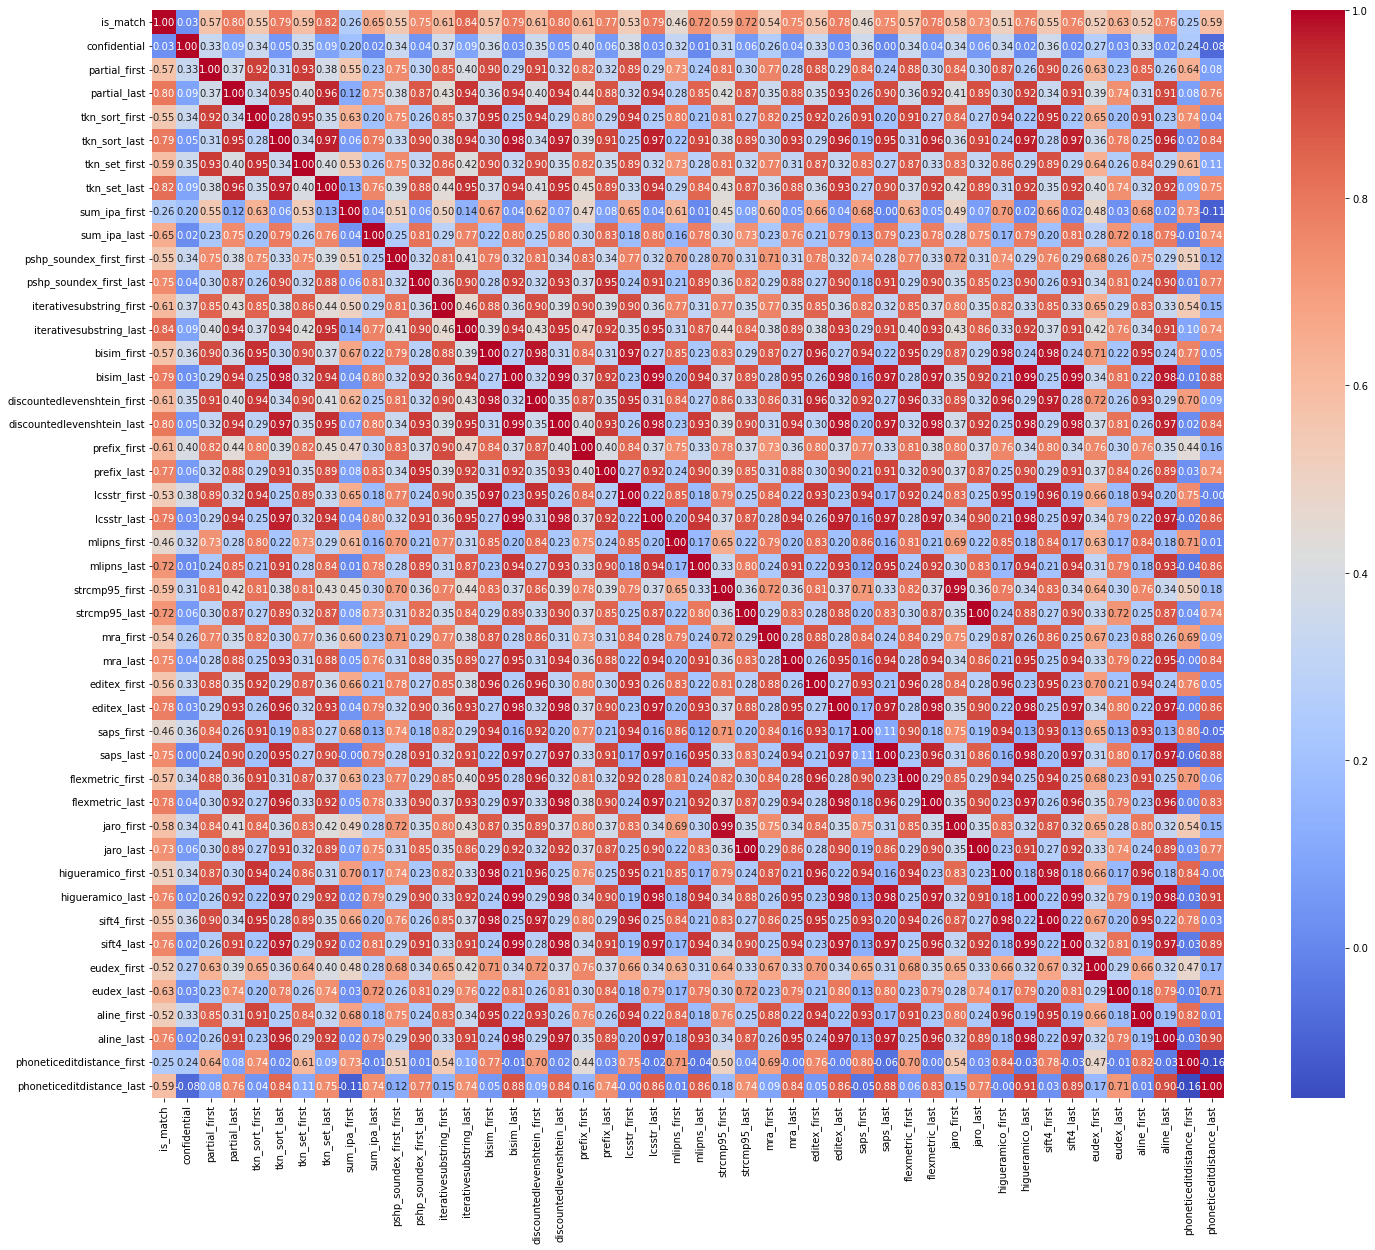

In [16]:
corr = df.corr()
plt.subplots(figsize=(24,20))
sns.heatmap(round(corr, 2), annot=True, fmt='.2f', cmap="coolwarm");

In [6]:
# Extract target dependent variable to y
y = df.is_match

In [8]:
# Extract independent feature variables to X
drop_cols = ['is_match', 'key', 'list_first_name', 'list_last_name', 'txn_first_name', 'txn_last_name', 
             'confidential', 'syll_list_first', 'syll_txn_first', 'syll_list_last', 'syll_txn_last']
X = df.drop(columns=drop_cols, axis=1)

In [9]:
X.head()

,partial_first,partial_last,tkn_sort_first,tkn_sort_last,tkn_set_first,tkn_set_last,sum_ipa_first,sum_ipa_last,pshp_soundex_first_first,pshp_soundex_first_last,...,higueramico_first,higueramico_last,sift4_first,sift4_last,eudex_first,eudex_last,aline_first,aline_last,phoneticeditdistance_first,phoneticeditdistance_last
0,92,100,92,100,92,100,1.000000,1.000000,1,1,...,0.833333,1.000000,0.833333,1.000000,0.980392,1.00000,0.764706,1.000000,0.833333,1.000000
1,83,100,73,100,73,100,0.967742,1.000000,1,1,...,0.600000,1.000000,0.600000,1.000000,1.000000,1.00000,0.891304,1.000000,0.793548,1.000000
2,75,100,62,100,62,100,0.940860,1.000000,1,1,...,0.347619,1.000000,0.428571,1.000000,0.987255,1.00000,0.432432,1.000000,0.566820,1.000000
3,100,85,100,86,100,86,1.000000,0.994624,1,1,...,1.000000,0.690476,1.000000,0.714286,1.000000,0.97598,1.000000,0.658537,1.000000,0.714286
4,95,100,90,100,90,100,0.704301,1.000000,1,1,...,0.777778,1.000000,0.875000,1.000000,0.988235,1.00000,0.725000,1.000000,0.967742,1.000000


In [10]:
# Call train_test_split on X, y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(77686, 44) (77686,)
(19422, 44) (19422,)


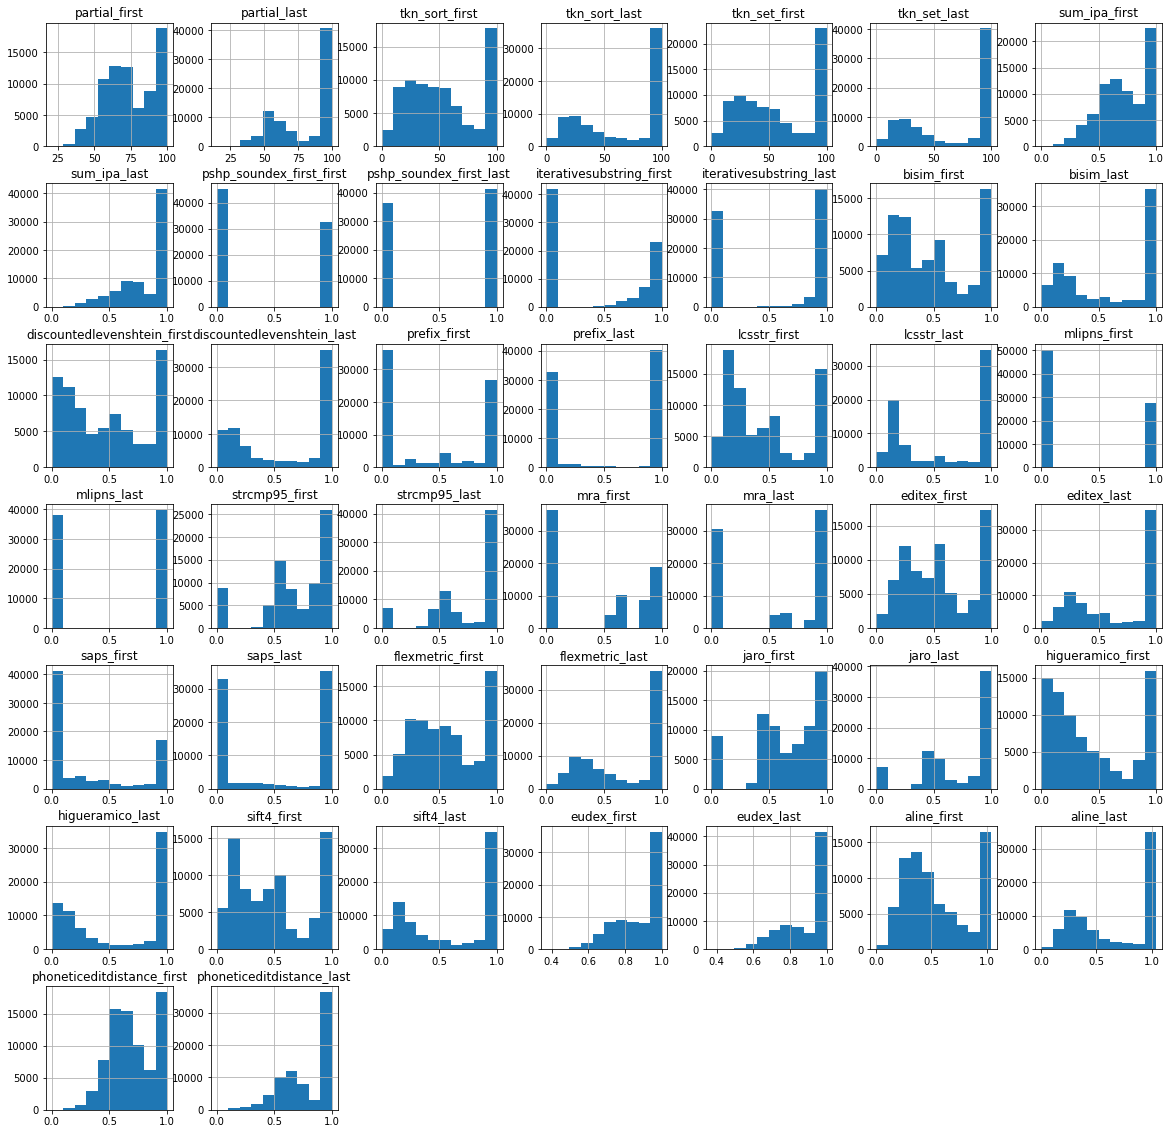

In [11]:
X_train.hist(figsize=(20, 20))
plt.show()

## Scale Features

In [14]:
# Apply a standard scaler to the training and test data
SS_scaler = StandardScaler()
X_train_scaled = SS_scaler.fit_transform(X_train)
X_test_scaled = SS_scaler.transform(X_test)

## Model Tuning & Evaluation

In [18]:
def model_tune(model_id, model, param_dist):
    # Instantiate the RandomizedSearchCV object: model_cv
    model_cv = RandomizedSearchCV(model, param_dist, cv=5)

    # Fit it to the data
    model_cv.fit(X_train, y_train.values.ravel())

    # Print the tuned parameters and score
    print("Model: {}".format(model_id))
    print("Tuned Hyper Parameters: {}".format(model_cv.best_params_))
    print("Best score is {}".format(model_cv.best_score_))
    
    # Fit model with optimal hyper parameters
    model.set_params(**model_cv.best_params_)
    model.fit(X_train, y_train.values.ravel())
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print(f"Train Score: {score_train}")
    print(f"Test Score: {score_test}")
    
    # Calculate Accuracy Score
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print("Accuracy Score:", score)

    df_plot_res = y_test.copy()
    df_plot_res['predicted_match'] = y_pred
    
    # Plot Results
    fig, ax = plt.subplots(figsize=(20, 10))   
    plt.plot(range(df_plot_res.shape[0]), 'is_match', data=df_plot_res.sort_values('is_match'), label='actual', color='b')
    plt.scatter(range(df_plot_res.shape[0]), 'predicted_match', data=df_plot_res.sort_values('is_match'), 
                label='predicted', color='r', alpha=0.5)
    plt.xlabel('Count')
    plt.ylabel('Match')
    plt.legend()
    plt.title('Sales Price - Actual vs. Predicted')
    plt.show()

    # Append results to DataFrame
    res = pd.DataFrame([[model_id, model_cv.best_params_, score_train, score_test, score]], 
                      columns=['Model', 'Parms', 'Score_Train', 'Score_Test', 'Accuracy_Score'])
    return res, y_pred

### XGBoost Classifier

In [ ]:
xgb = XGBClassifier()
param_dist = {
            'n_estimators': [10, 50, 100, 500, 1000],
            'max_depth': [2, 3, 5, 10, 15],
            'learning_rate': [0.05, 0.1, 0.15, 0.20],
            'min_child_weight': [1, 2, 3, 4]
            }
res, y_pred_xgb = model_tune('XGB', xgb, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

In [ ]:
xgb.feature_importances_

In [ ]:
xgb_feat_imp = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: -x[1])
xgb_feat_imp = pd.DataFrame(xgb_feat_imp)
xgb_feat_imp.columns=["Feature", "Weight"]
xgb_feat_imp.head(20)

In [ ]:
plt.subplots(figsize=(10, 5))
sns.barplot(y="Feature", x="Weight", data=xgb_feat_imp, orient = 'h')
plt.xlabel('Weight')
plt.ylabel('Feature')
# plt.xticks(rotation = 90)
plt.title('Feature Importance')
sns.despine()
plt.show()